<a href="https://colab.research.google.com/github/Aleena-Shafiq/Renalystic/blob/main/Copy_of_FYP_IMAGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Install necessary libraries
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *
from fastai.vision.models import xresnet

# Add this import for xresnet
from fastai.vision.models import xresnet

Mounted at /content/gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s 

In [ ]:
# Define paths and load the dataset
path = Path('/content/gdrive/My Drive/Dataset')
train_fnames = get_image_files(path/"Train")

# Data block and DataLoader setup (replace this with your data loading code)
augs = [RandomResizedCropGPU(size=224, min_scale=0.75), Rotate(), Zoom()]
dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.2, seed=23),
                   get_y=parent_label,
                   item_tfms=Resize(512, method="squish"),
                   batch_tfms=augs,
                   )
dls = dblock.dataloaders(train_fnames)


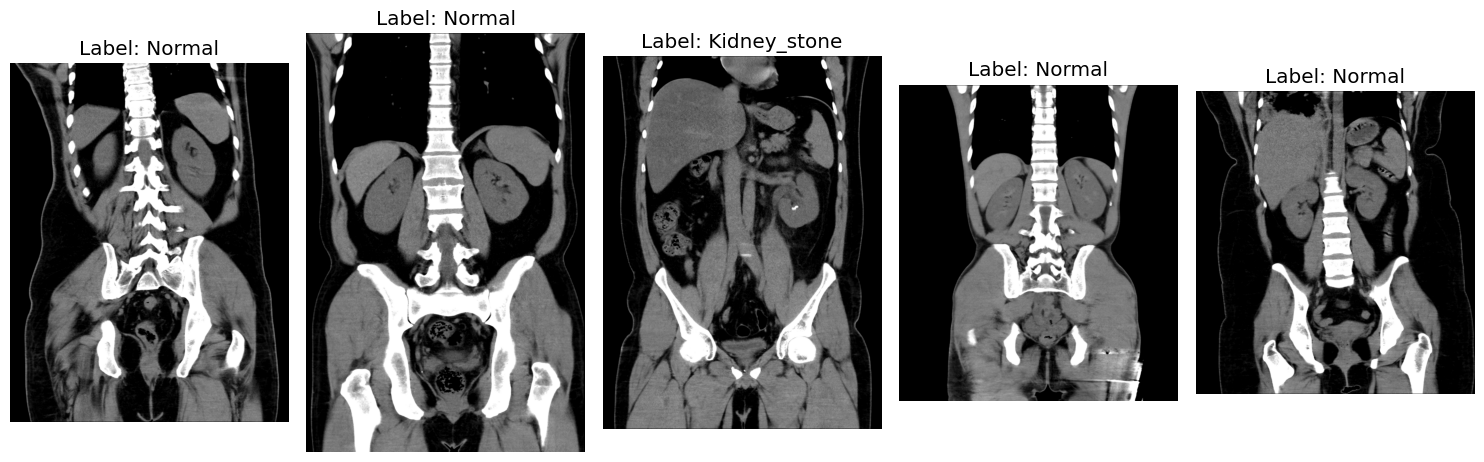

In [ ]:
# Visualize augmented images
augmented_images = [dls.train_ds[idx][0] for idx in range(5)]  # Get 5 augmented images from the training set
augmented_labels = [dls.train_ds[idx][1] for idx in range(5)]  # Get labels for augmented images

plt.figure(figsize=(15, 6))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    ax.set_title(f'Label: {dls.train_ds.vocab[augmented_labels[i]]}')
    ax.imshow(augmented_images[i])  # Plot the PIL image directly
    ax.axis('off')
plt.tight_layout()
plt.show()


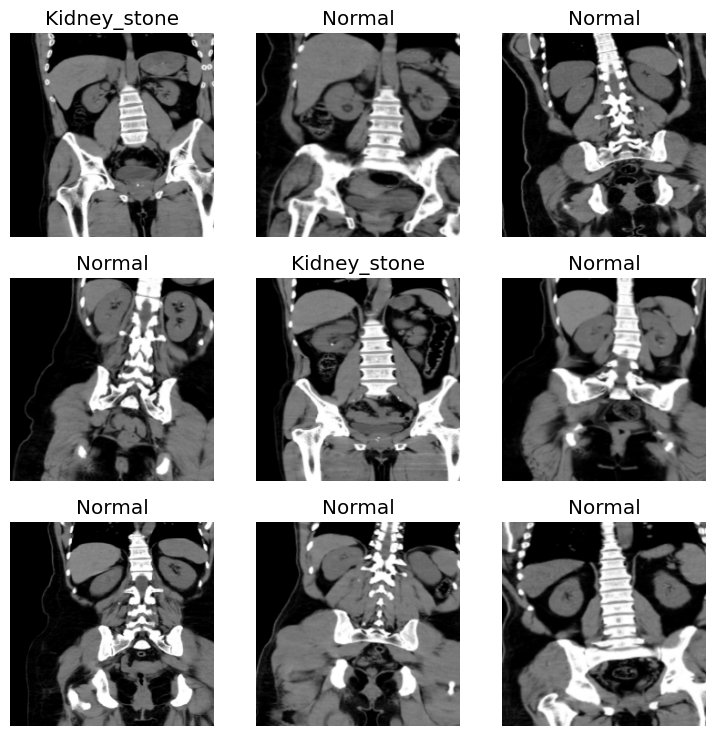

In [ ]:
dls.c, len(dls.train_ds), len(dls.valid_ds)
dls.vocab
dls.show_batch()

# Model setup
model = nn.Sequential(create_body(xresnet.xresnet50(pretrained=False), cut=-4),
                      create_head(nf=2048, n_out=2))
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)


epoch,train_loss,valid_loss,accuracy,time
0,0.868996,0.700085,0.592466,02:13
1,0.765329,0.769492,0.602740,00:57
2,0.712873,0.703862,0.554795,00:58
3,0.685862,1.415254,0.599315,00:59
4,0.679563,0.779287,0.482877,00:58
5,0.685792,9.188953,0.589041,00:57
6,0.687544,0.620138,0.708904,00:58
7,0.688373,0.470729,0.797945,01:02
8,0.644231,8.132213,0.410959,00:58
9,0.594692,1.994400,0.479452,00:58


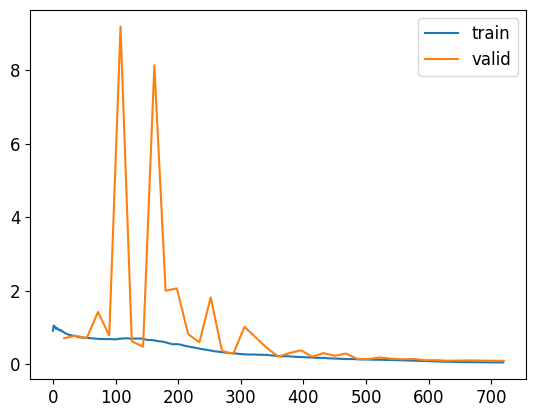

In [ ]:
# Train the model
learn.fit_one_cycle(40, 1e-2)
learn.save(path/'kidney-50')
learn.recorder.plot_loss(skip_start=0, with_valid=True)


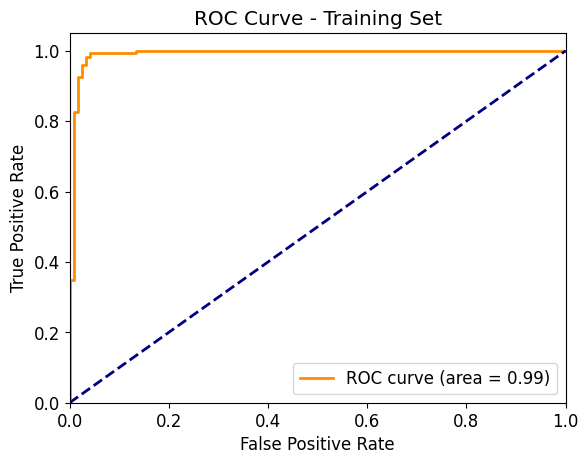

In [ ]:
from sklearn.metrics import roc_curve, auc



# Calculate probabilities for the training set
probs_train, targets_train = learn.get_preds()

# Calculate ROC curve and AUC for training set
fpr, tpr, thresholds = roc_curve(targets_train, probs_train[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Set')
plt.legend(loc="lower right")
plt.show()


              precision    recall  f1-score   support

Kidney_stone       0.99      0.95      0.97       120
      Normal       0.97      0.99      0.98       172

    accuracy                           0.98       292
   macro avg       0.98      0.97      0.98       292
weighted avg       0.98      0.98      0.98       292



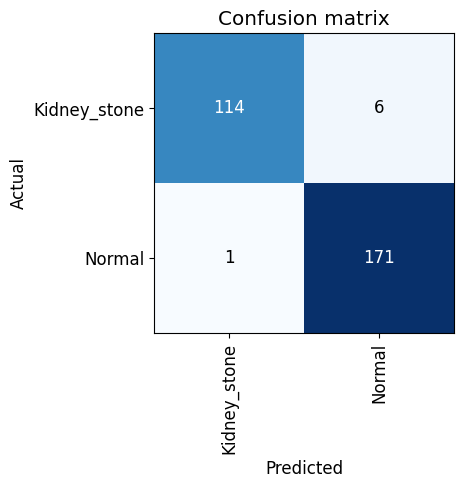

In [ ]:
# Training set confusion matrix and classification report
interp_train = ClassificationInterpretation.from_learner(learn)
interp_train.plot_confusion_matrix()
interp_train.print_classification_report()

In [ ]:
torch.save(dls, path/'dls.pkl')

In [ ]:
all_files= get_image_files(path)

augs = [RandomResizedCropGPU(size=224, min_scale=0.75), Rotate(), Zoom()]
dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   splitter=GrandparentSplitter(train_name='Train', valid_name='Test'),
                   get_y=parent_label,
                   item_tfms=Resize(512, method="squish"),
                   batch_tfms=augs,
                   )

dls_test = dblock.dataloaders(all_files)
print("Number of examples in testing:", len(dls_test.valid_ds))


Number of examples in testing: 346


              precision    recall  f1-score   support

Kidney_stone       0.96      0.95      0.96       165
      Normal       0.96      0.97      0.96       181

    accuracy                           0.96       346
   macro avg       0.96      0.96      0.96       346
weighted avg       0.96      0.96      0.96       346



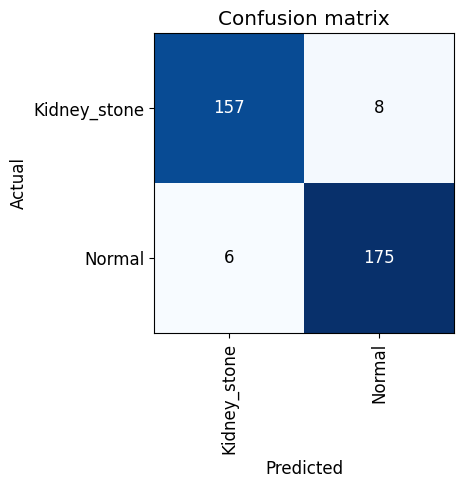

In [ ]:
model = nn.Sequential(create_body(xresnet50(), pretrained=False), create_head(nf=2048, n_out=2))
learn1 = Learner(dls_test, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy).load('/content/gdrive/My Drive/Dataset/kidney-50')

interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()
interp.print_classification_report()
